# skin ILCs scATAC processing notebook

Notebook used for processing of scATAC datasets, ran with
- R version 3.6.0

Libraries used and versions
- Seurat_3.1.1
- Signac_0.1.6
- GenomeInfoDb_1.20.0
- EnsDb.Mmusculus.v79_2.99.0
- ggplot2_3.2.1
- BSgenome.Mmusculus.UCSC.mm10_1.4.0
- TFBSTools_1.22.0 
- JASPAR2018_1.1.1

In [3]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
set.seed(1234)


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vecto

In [4]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux

Matrix products: default
BLAS/LAPACK: /ahg/regevdata/users/etorlait/software/anaconda3/envs/R3.6/lib/R/lib/libRblas.so

locale:
[1] C

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.2.1              EnsDb.Mmusculus.v79_2.99.0
 [3] ensembldb_2.8.0            AnnotationFilter_1.8.0    
 [5] GenomicFeatures_1.36.4     AnnotationDbi_1.46.1      
 [7] Biobase_2.44.0             GenomicRanges_1.36.1      
 [9] GenomeInfoDb_1.20.0        IRanges_2.18.2            
[11] S4Vectors_0.22.0           BiocGenerics_0.30.0       
[13] Seurat_3.1.1               Signac_0.1.6              

loaded via a namespace (and not attached):
  [1] reticulate_1.13             R.utils_2.9.0              
  [3] tidyselect_0.2.5            poweRlaw_0.70.2            
  [5] RSQLite_2.1.2

### Input - CR aggregated - filtered for barcode multiplets -  naive and IL23 samples

In [6]:
counts <- Read10X_h5(".....CR_aggr/outs/filtered_peak_bc_matrix.h5")

metadata <- read.csv(
  file = ".....CR_aggr/outs/outs/singlecell.csv",
  header = TRUE,
  row.names = 1
)

silc <- CreateSeuratObject(
  counts = counts,
  assay = 'peaks',
  project = 'ATAC',
  min.cells = 1,
  meta.data = metadata
)

Warning message in CreateSeuratObject(counts = counts, assay = "peaks", project = "ATAC", :
"Some cells in meta.data not present in provided counts matrix."

In [7]:
fragment.path <- '.....CR_aggr/outs/fragments.tsv.gz'

silc <- SetFragments(
  object = silc,
  file = fragment.path
)

In [8]:
silc

An object of class Seurat 
63252 features across 8773 samples within 1 assay 
Active assay: peaks (63252 features)

In [9]:
fragment_file_filtered <- ".....CR_aggr/outs/fragments_filtered.tsv"


In [10]:
#Run it just once - slow
###FilterFragments(
#  fragment.path = fragment.path,
#  cells = colnames(silc),
#  output.path = fragment_file_filtered
#)

In [11]:
silc <- SetFragments(object = silc, file = paste0(fragment_file_filtered, '.bgz'))


### Computing QC metrics

In [12]:
silc <- NucleosomeSignal(object = silc)


Extracting reads in requested region
Computing ratio of mononucleosomal to nucleosome-free fragments


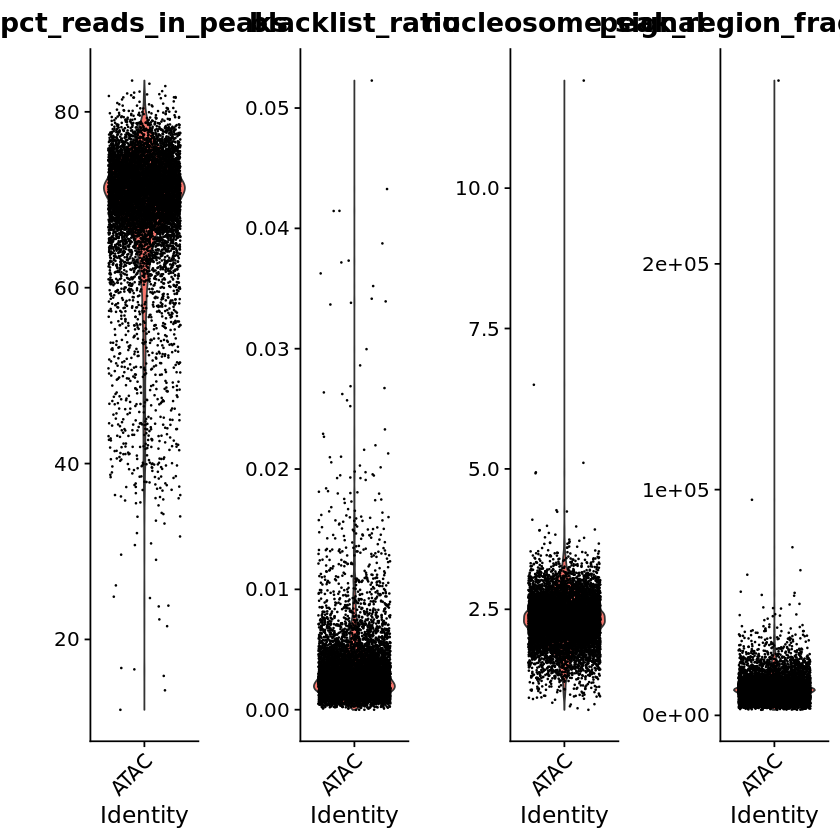

In [13]:
silc$pct_reads_in_peaks <- silc$peak_region_fragments / silc$passed_filters * 100
silc$blacklist_ratio <- silc$blacklist_region_fragments / silc$peak_region_fragments

VlnPlot(
  object = silc,
  features = c('pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_signal', 'peak_region_fragments'),
  pt.size = 0.1,
  ncol = 4) + NoLegend()

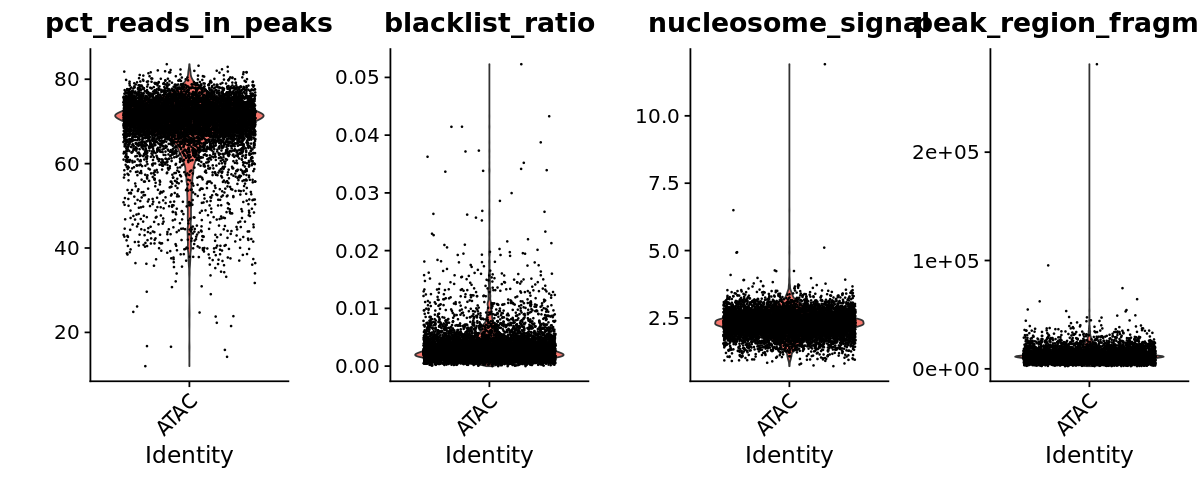

In [14]:
options(repr.plot.width=10, repr.plot.height=4)
VlnPlot(
  object = silc,
  features = c('pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_signal', 'peak_region_fragments'),
  pt.size = 0.1,
  ncol = 4) + NoLegend()

Warning message:
"Removed 8 rows containing non-finite values (stat_bin)."Warning message:
"Removed 4 rows containing missing values (geom_bar)."

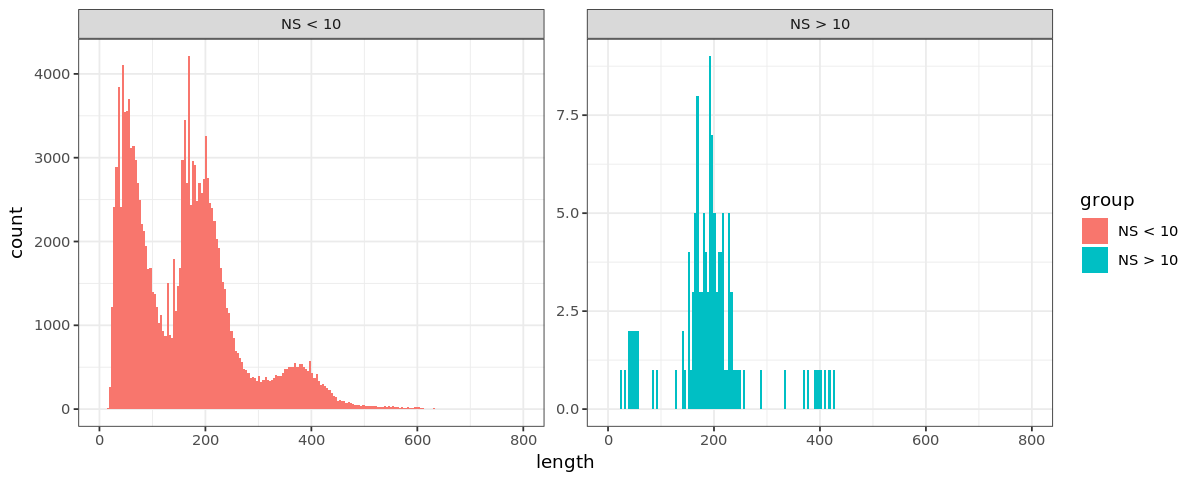

In [15]:
silc$nucleosome_group <- ifelse(silc$nucleosome_signal > 10, 'NS > 10', 'NS < 10')
PeriodPlot(object = silc, group.by = 'nucleosome_group', region = 'chr1-1-10000000')

Warning message:
"Removed 8 rows containing non-finite values (stat_bin)."Warning message:
"Removed 4 rows containing missing values (geom_bar)."

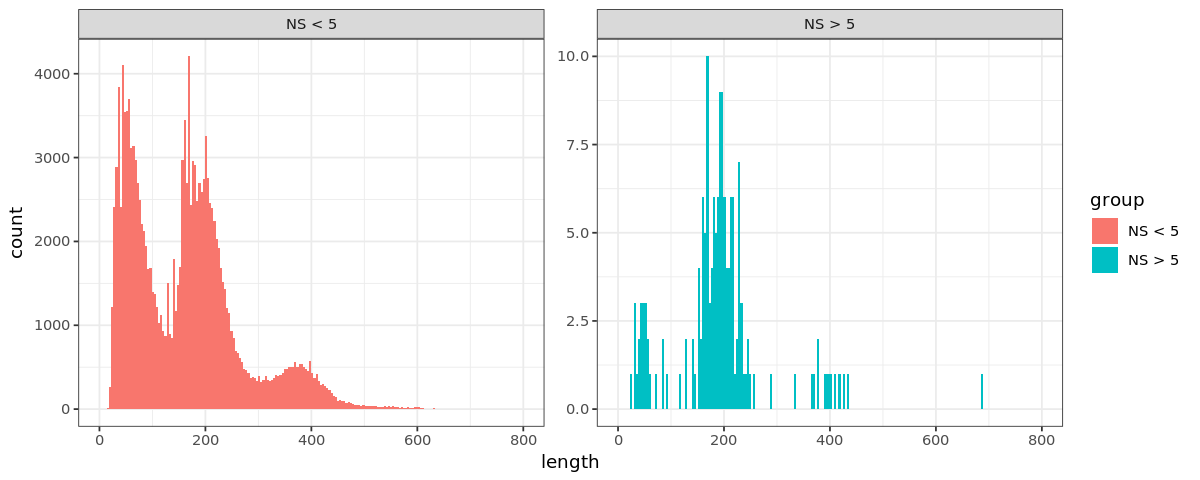

In [16]:
silc$nucleosome_group <- ifelse(silc$nucleosome_signal > 5, 'NS > 5', 'NS < 5')
PeriodPlot(object = silc, group.by = 'nucleosome_group', region = 'chr1-1-10000000')

Warning message:
"Removed 8 rows containing non-finite values (stat_bin)."Warning message:
"Removed 4 rows containing missing values (geom_bar)."

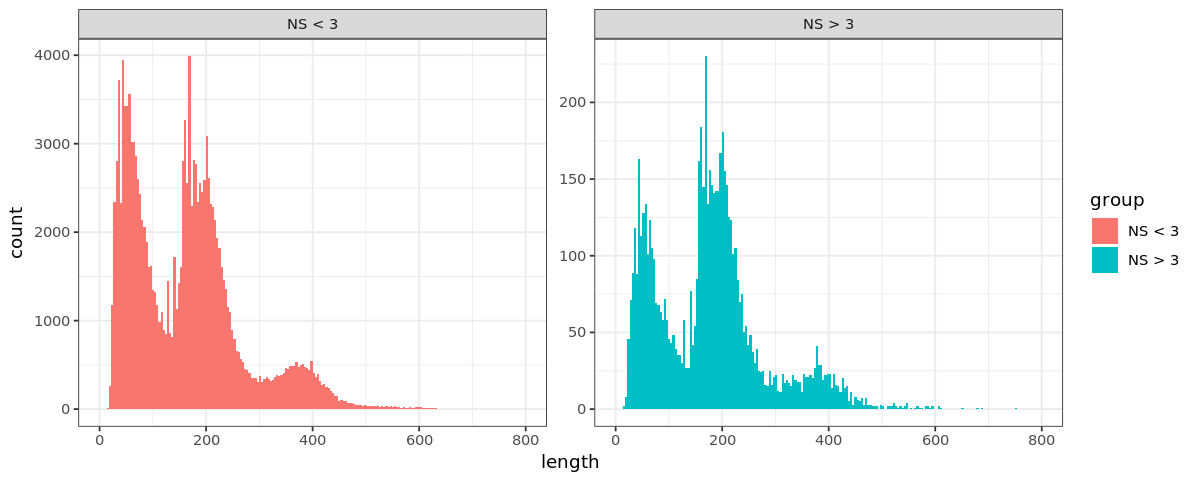

In [17]:
silc$nucleosome_group <- ifelse(silc$nucleosome_signal > 3, 'NS > 3', 'NS < 3')
PeriodPlot(object = silc, group.by = 'nucleosome_group', region = 'chr1-1-10000000')

In [18]:
# create granges object with TSS positions
gene.ranges <- genes(EnsDb.Mmusculus.v79)
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]

tss.ranges <- GRanges(
  seqnames = seqnames(gene.ranges),
  ranges = IRanges(start = start(gene.ranges), width = 2),
  strand = strand(gene.ranges)
)

seqlevelsStyle(tss.ranges) <- 'UCSC'
tss.ranges <- keepStandardChromosomes(tss.ranges, pruning.mode = 'coarse')

# to save time use the first 2000 TSSs
silc <- TSSEnrichment(object = silc, tss.positions = tss.ranges[1:2000])

Finding + strand cut sites
Finding - strand cut sites
Computing mean insertion frequency in flanking regions
Normalizing TSS score


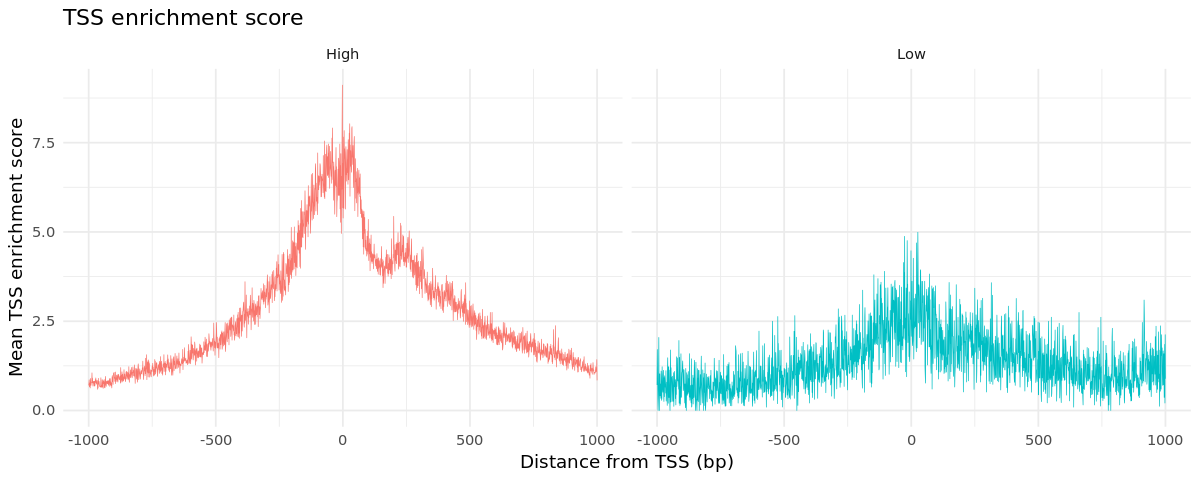

In [19]:
silc$high.tss <- ifelse(silc$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(silc, group.by = 'high.tss') + ggtitle("TSS enrichment score") + NoLegend()


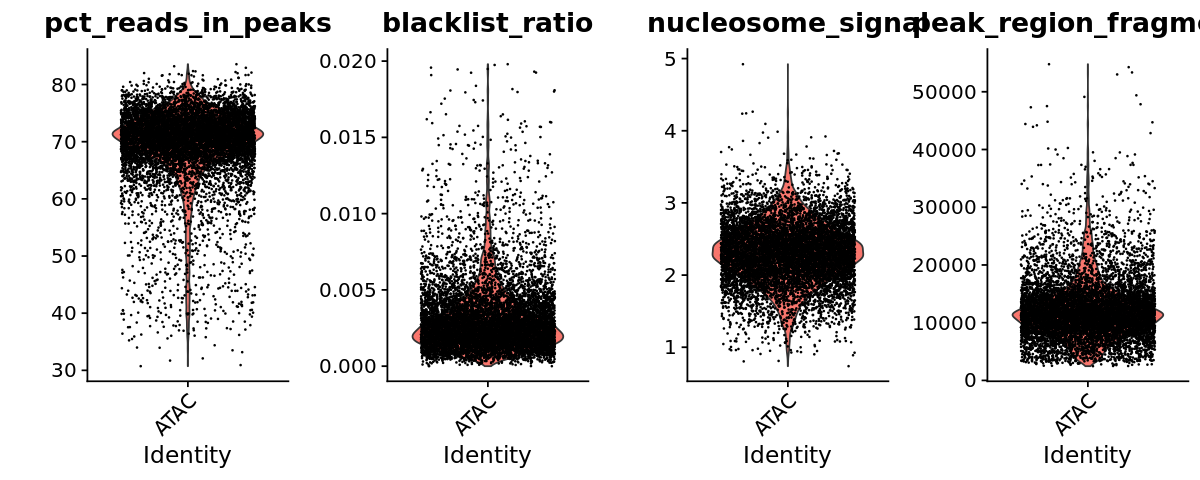

In [20]:
silc <- subset(silc, subset = pct_reads_in_peaks> 30 & peak_region_fragments < 60000 &  blacklist_ratio < 0.02 & nucleosome_signal < 5)

VlnPlot(
  object = silc,
  features = c('pct_reads_in_peaks', 'blacklist_ratio', 'nucleosome_signal', 'peak_region_fragments'),
  pt.size = 0.1,
  ncol = 4) + NoLegend()

In [21]:
summary(silc$peak_region_fragments)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2463    9122   11470   12204   14108   54777 

In [22]:
silc <- subset(silc, subset = peak_region_fragments > 2500 & peak_region_fragments < 60000 &  blacklist_ratio < 0.02 & nucleosome_signal < 5 & pct_reads_in_peaks > 35 & TSS.enrichment > 2)

### Apply proper labels to aggregated datasets

In [23]:
silc

An object of class Seurat 
63252 features across 8676 samples within 1 assay 
Active assay: peaks (63252 features)

In [24]:
gemgroup <- sapply(strsplit(rownames(silc@meta.data), split="-"), "[[", 2) 
head(gemgroup)

[1] "1" "2" "2" "1" "2" "2"

In [25]:
silc <- AddMetaData(object=silc, metadata=data.frame(gemgroup=gemgroup, row.names=rownames(silc@meta.data)))

In [26]:
samplename = silc@meta.data$gemgroup
table(samplename)

sampleid = rep("1.WT_naive",length(samplename))
sampleid[samplename %in% c("2")] = "2.WT_IL23"
names(sampleid) = rownames(silc@meta.data)

silc <- AddMetaData(
  object = silc,
  metadata = sampleid,
  col.name = "sampleid")

table(silc@meta.data$sampleid)

samplename
   1    2 
4470 4206 


1.WT_naive  2.WT_IL23 
      4470       4206 

### Normalization and linear dimensional reduction


In [27]:
silc <- RunTFIDF(silc)
silc <- FindTopFeatures(silc, min.cutoff = 'q0')
silc <- RunSVD(
  object = silc,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi'
)

Performing TF-IDF normalization
Running SVD
Scaling cell embeddings


### Non-linear dimension reduction and clustering


Computing nearest neighbor graph
Computing SNN
Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."

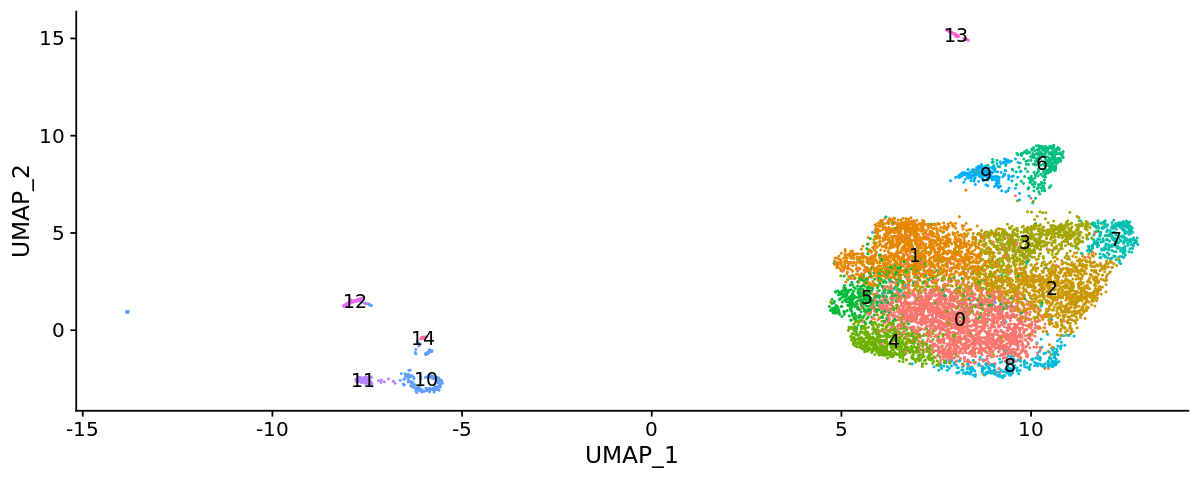

In [28]:
silc <- RunUMAP(
  object = silc,
  reduction = 'lsi',
  dims = 1:30,
  umap.method= 'umap-learn',
  metric = 'correlation'
)
silc <- FindNeighbors(
  object = silc,
  reduction = 'lsi',
  dims = 1:30
)
silc <- FindClusters(
  object = silc,
  verbose = FALSE
)

DimPlot(object = silc, label = TRUE) + NoLegend()

### Non-linear dimension reduction and clustering


### Create a gene activity matrix

In [29]:
#extract gene coordinates from Ensembl, and ensure name formatting is consistent with  Seurat object 
gene.coords <- genes(EnsDb.Mmusculus.v79, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(gene.coords) <- 'UCSC'
genebody.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
genebodyandpromoter.coords <- Extend(x = gene.coords, upstream = 2000, downstream = 0)

# build a gene by cell matrix
gene.activities <- FeatureMatrix(
  fragments = fragment.path,
  features = genebodyandpromoter.coords,
  cells = colnames(silc),
  chunk = 10
)

# convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- make.unique(gene.key[rownames(gene.activities)])
gene.activities <- gene.activities[rownames(gene.activities)!="",]

#Add the gene activity matrix to the Seurat object as a new assay, and normalize it
silc[['RNA']] <- CreateAssayObject(counts = gene.activities)
silc <- NormalizeData(
  object = silc,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(silc$nCount_RNA)
)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 3 out-of-bound ranges located on sequences
  JH584293.1, JH584295.1, and JH584296.1. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information."Extracting reads overlapping genomic regions
Constructing matrix


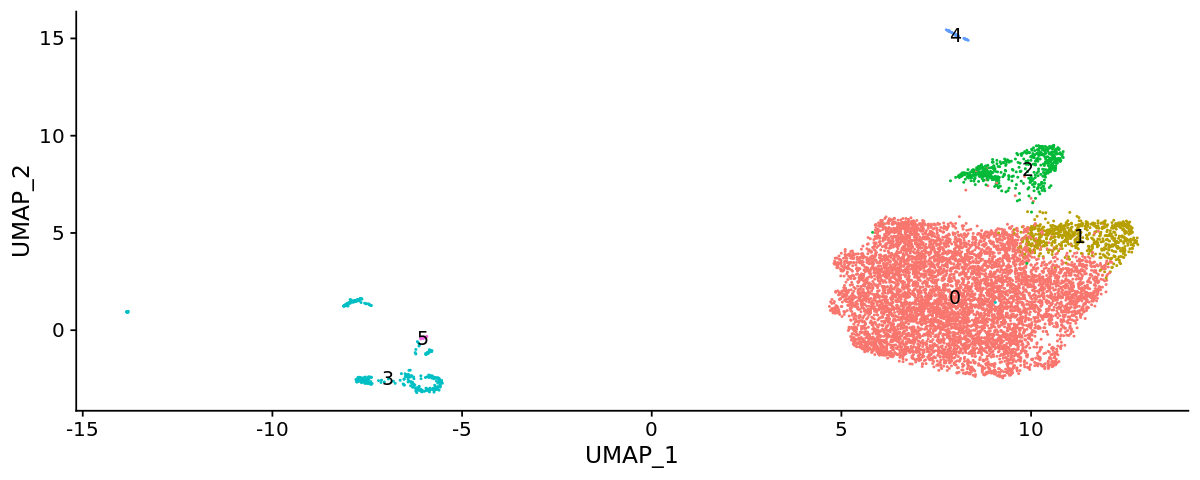

In [30]:
silc <- FindClusters(
  object = silc,
  verbose = FALSE, 
  resolution = 0.1
)

DimPlot(object = silc, label = TRUE) + NoLegend()

In [31]:
#working with gene activities instead of peaks
DefaultAssay(silc) <- 'RNA'

da_genes <- FindMarkers(
  object = silc,
  ident.1 = c("3"),
  ident.2 = c("0","1","2"),
  min.pct = 0.4
)


In [32]:
da_genes

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Parva,0,1.6283670,0.887,0.125,0
Stard13,0,1.5443901,0.936,0.143,0
Adamts9,0,1.4491246,0.907,0.109,0
Col6a3,0,1.4111847,0.775,0.052,0
Htra1,0,1.3640512,0.862,0.085,0
Trabd2b,0,1.3488836,0.907,0.132,0
Kirrel,0,1.3421200,0.865,0.139,0
Prrx1,0,1.2476223,0.746,0.097,0
Ppap2b,0,1.1876715,0.836,0.112,0


In [33]:
da_genes2 <- FindMarkers(
  object = silc,
  ident.1 = c("4"),
  ident.2 = c("0","1","2"),
  min.pct = 0.4
)


In [34]:
da_genes3 <- FindMarkers(
  object = silc,
  ident.1 = c("5"),
  ident.2 = c("0","1","2"),
  min.pct = 0.4
)

In [35]:
head(da_genes2)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Ccl9,1.075582e-194,0.6057699,0.435,0.007,2.316265e-190
Sirpa,8.211745e-177,1.6200773,0.935,0.047,1.768399e-172
Trem1,2.116351e-115,0.6584427,0.413,0.012,4.557563e-111
Cd33,1.529521e-104,0.8334139,0.630,0.034,3.293823e-100
Clec4d,1.003373e-103,1.0239745,0.478,0.019,2.160763e-99
F7,4.948101e-102,0.6779087,0.457,0.018,1.065573e-97


In [36]:
head(da_genes3)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Krt14,0,0.8735211,0.826,0.009,0
Psapl1,0,0.7502716,0.696,0.005,0
Gjb4,0,0.7082975,0.696,0.004,0
Gjb5,0,0.5862233,0.696,0.005,0
Rassf10,0,0.5657494,0.652,0.004,0
Krt15,0,0.5227283,0.609,0.004,0


### Filter outlier cells

In [37]:
silc2=subset(silc, idents = c("0", "1", "2"))

In [38]:
silc2

An object of class Seurat 
84787 features across 8296 samples within 2 assays 
Active assay: RNA (21535 features)
 1 other assay present: peaks
 2 dimensional reductions calculated: lsi, umap

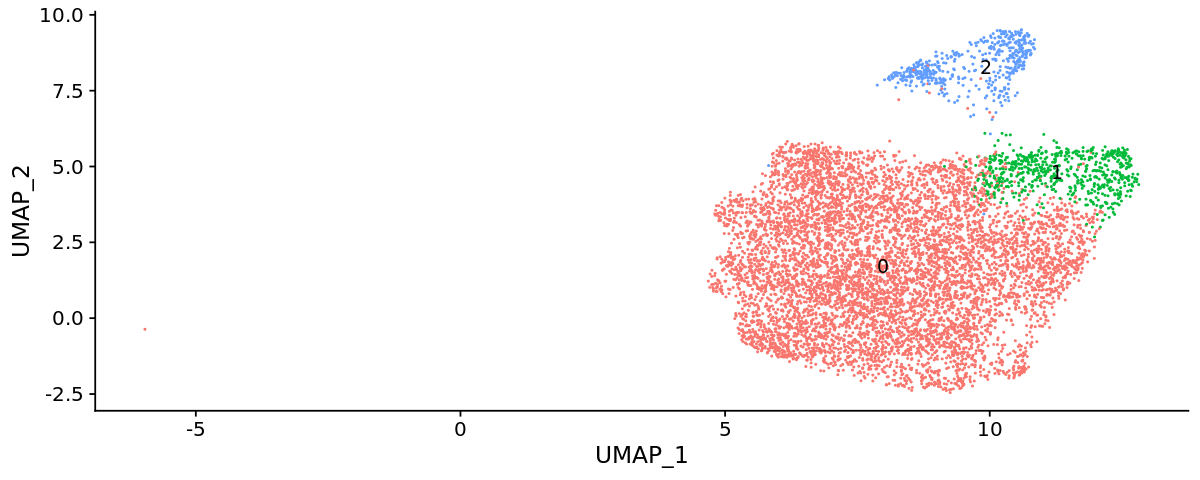

In [39]:
DimPlot(object = silc2, label = TRUE) + NoLegend()

In [40]:
selected_cells=colnames(silc2)

In [41]:
head(selected_cells)

[1] "AAACGAAAGACCGCAA-1" "AAACGAAAGCGTGTTT-2" "AAACGAAAGGGAAGCG-2"
[4] "AAACGAAAGTTCAGGG-2" "AAACGAACACAACGGA-1" "AAACGAACACATTCTT-1"

In [42]:
length(selected_cells)

[1] 8296

# Reload the data and process without lowQ and contaminant cells 

In [43]:
silc3 <- CreateSeuratObject(
  counts = counts,
  assay = 'peaks',
  project = 'ATAC',
  min.cells = 1,
  meta.data = metadata
)

fragment.path <- '/ahg/regevdata/projects/skinILCs/sc_ATAC_1902.skin_Flavell/Aggregate/ILC_WT_cleanbarcode_atac/outs/fragments_filtered.tsv.bgz'

silc3 <- SetFragments(
  object = silc3,
  file = fragment.path
)

Warning message in CreateSeuratObject(counts = counts, assay = "peaks", project = "ATAC", :
"Some cells in meta.data not present in provided counts matrix."

In [44]:
silc3=SubsetData(object = silc3, cells = selected_cells)

Warning message:
"'SubsetData' is deprecated.
Use 'subset' instead.
See help("Deprecated")"Warning message:
"'OldWhichCells' is deprecated.
Use 'WhichCells' instead.
See help("Deprecated")"

In [45]:
silc3

An object of class Seurat 
63252 features across 8296 samples within 1 assay 
Active assay: peaks (63252 features)

### Add annotations

In [46]:
gemgroup2 <- sapply(strsplit(rownames(silc3@meta.data), split="-"), "[[", 2) 
head(gemgroup2)

[1] "1" "2" "2" "2" "1" "1"

In [47]:
silc3 <- AddMetaData(object=silc3, metadata=data.frame(gemgroup2=gemgroup2, row.names=rownames(silc3@meta.data)))

In [48]:
samplename = silc3@meta.data$gemgroup2
table(samplename)

sampleid = rep("1.WT_naive",length(samplename))
sampleid[samplename %in% c("2")] = "2.WT_IL23"
names(sampleid) = rownames(silc3@meta.data)

silc3 <- AddMetaData(
  object = silc3,
  metadata = sampleid,
  col.name = "sampleid")

table(silc3@meta.data$sampleid)

samplename
   1    2 
4179 4117 


1.WT_naive  2.WT_IL23 
      4179       4117 

### Normalization and linear dimensional reduction


In [49]:
silc3 <- RunTFIDF(silc3)
silc3 <- FindTopFeatures(silc3, min.cutoff = 'q0')
silc3 <- RunSVD(
  object = silc3,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi'
)

Performing TF-IDF normalization
Running SVD
Scaling cell embeddings


### Non-linear dimension reduction and clustering


In [50]:
silc3 <- RunUMAP(
  object = silc3,
  reduction = 'lsi',
  dims = 1:30, 
    umap.method= 'umap-learn',
    metric = 'correlation'
)

In [51]:
silc3 <- FindNeighbors(
  object = silc3,
  reduction = 'lsi',
  dims = 1:30
)

Computing nearest neighbor graph
Computing SNN


In [52]:
silc3 <- FindClusters(
  object = silc3,
  verbose = FALSE, 
    resolution =0.5
)


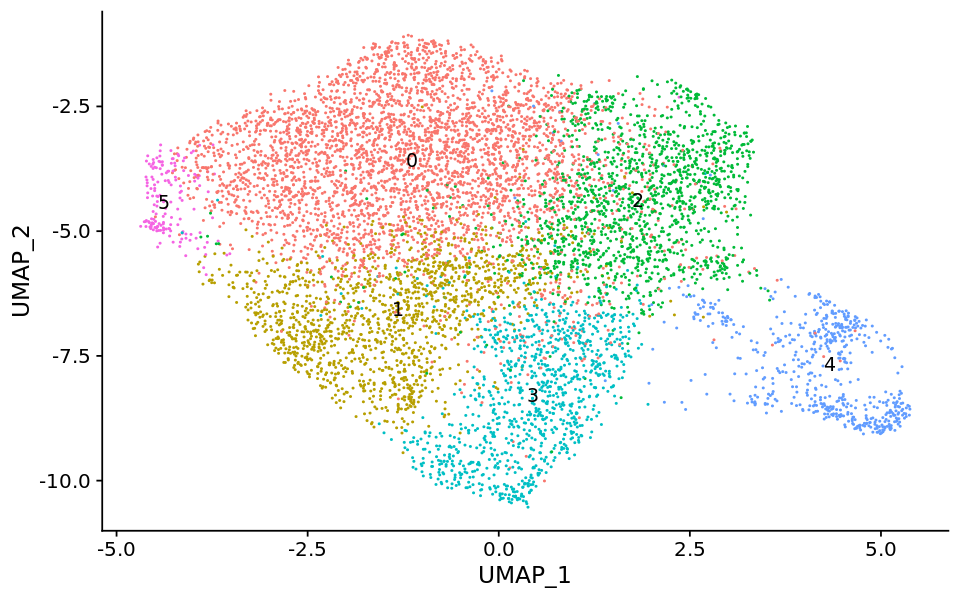

In [53]:
options(repr.plot.width=8, repr.plot.height=5)
DimPlot(object = silc3, label = TRUE) + NoLegend()

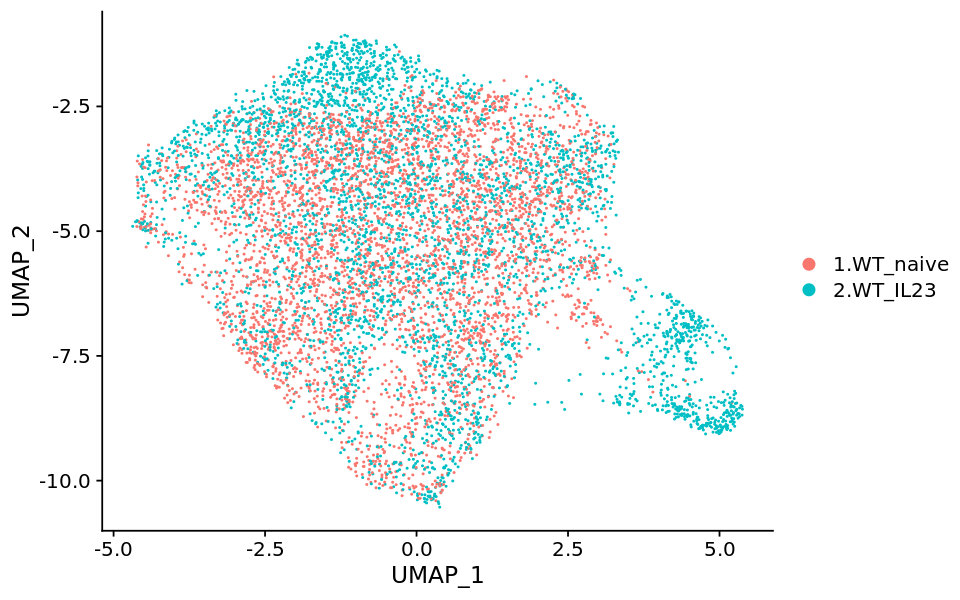

In [54]:
DimPlot(silc3, reduction = "umap", group.by = "sampleid")


In [55]:
#extract gene coordinates from Ensembl, and ensure name formatting is consistent with  Seurat object 
gene.coords <- genes(EnsDb.Mmusculus.v79, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(gene.coords) <- 'UCSC'
genebody.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
genebodyandpromoter.coords <- Extend(x = gene.coords, upstream = 2000, downstream = 0)

# build a gene by cell matrix
gene.activities <- FeatureMatrix(
  fragments = fragment.path,
  features = genebodyandpromoter.coords,
  cells = colnames(silc3),
  chunk = 10
)

# convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- make.unique(gene.key[rownames(gene.activities)])
gene.activities <- gene.activities[rownames(gene.activities)!="",]

#Add the gene activity matrix to the Seurat object as a new assay, and normalize it
silc3[['RNA']] <- CreateAssayObject(counts = gene.activities)
silc3 <- NormalizeData(
  object = silc3,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(silc3$nCount_RNA)
)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 3 out-of-bound ranges located on sequences
  JH584293.1, JH584295.1, and JH584296.1. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information."Extracting reads overlapping genomic regions
Constructing matrix


## ChromVar

In [57]:
library(JASPAR2018)
library(TFBSTools)
library(BSgenome.Mmusculus.UCSC.mm10)
set.seed(1234)

Loading required package: BSgenome
Loading required package: Biostrings
Loading required package: XVector

Attaching package: 'Biostrings'

The following object is masked from 'package:base':

    strsplit

Loading required package: rtracklayer


In [58]:
silc3

An object of class Seurat 
84780 features across 8296 samples within 2 assays 
Active assay: peaks (63252 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

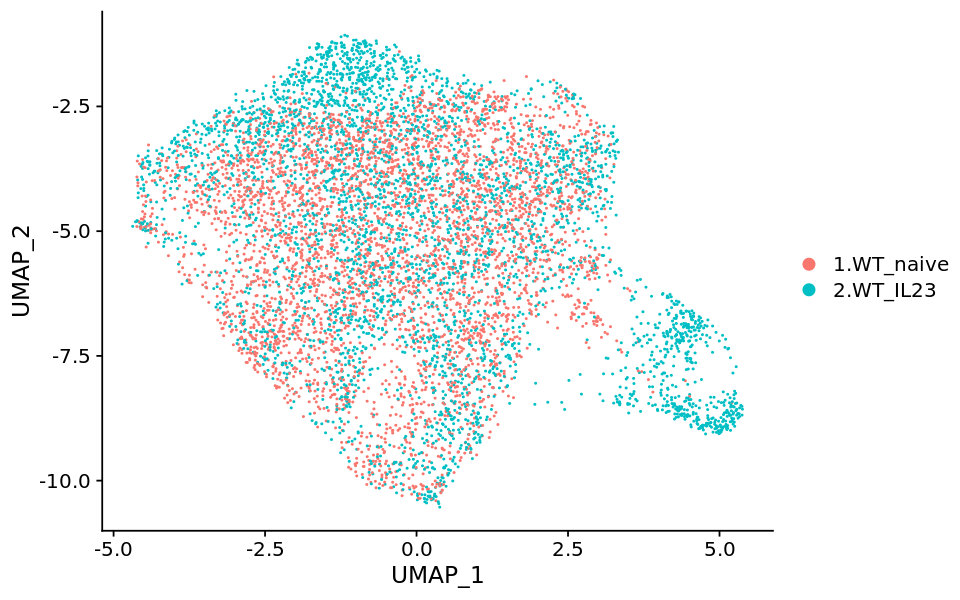

In [59]:
DimPlot(silc3, reduction = "umap", group.by = "sampleid")


In [60]:
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = TRUE)
)

## Specied 9606 is Homo Sapiens!!

In [61]:
## Specied 10090 is Mus Musculus

# Get a list of motif position weight matrices from the JASPAR database
pfm2 <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 10090, all_versions = TRUE)
)

In [62]:
pfm3=c(pfm, pfm2)

In [63]:
DefaultAssay(silc3) <- 'peaks'
silc3

An object of class Seurat 
84780 features across 8296 samples within 2 assays 
Active assay: peaks (63252 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

In [64]:
# Scan the DNA sequence of each peak for the presence of each motif
motif.matrix <- CreateMotifMatrix(
  features = StringToGRanges(rownames(silc3), sep = c(":", "-")),
  pwm = pfm3,
  genome = 'mm10',
  sep = c(":", "-")
)

In [65]:
# Create a new Mofif object to store the results
motif <- CreateMotifObject(
  data = motif.matrix,
  pwm = pfm3
)

In [66]:
# Add the Motif object to the assay
silc3[['peaks']] <- AddMotifObject(
  object = silc3[['peaks']],
  motif.object = motif
)

In [67]:
# In order to test for overrepresented motifs, we also need to compute some sequence characteristics of the peaks, such as GC content, sequence length, and dinucleotide frequency. 
silc3 <- RegionStats(
  object = silc3,
  genome = BSgenome.Mmusculus.UCSC.mm10,
  sep = c(":", "-")
)

In [68]:
silc3 <- RunChromVAR(
  object = silc3,
  genome = BSgenome.Mmusculus.UCSC.mm10
)

Computing GC bias per region
Selecting background regions
Computing motif deviations from background
Constructing chromVAR assay
Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"

In [69]:
silc3a=subset(silc3, sampleid == "1.WT_naive")
silc3b=subset(silc3, sampleid == "2.WT_IL23")


In [70]:
motif

A Motif object containing 713 motifs in 63252 regions

In [71]:
save.image(file = "scATAC_naive_IL23.RData")